# Optimization

In [1]:
import os
import sys
import math
import time
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from IPython import display
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [2]:
print(torch.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.0.1
cuda


In [3]:
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

In [4]:
def set_figsize(figsize=(4, 3)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

## 1. Local and Global Minimum

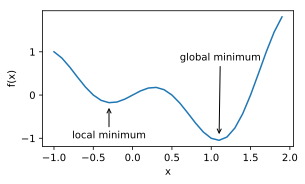

In [5]:
def f(x):
    return x * np.cos(np.pi * x)

set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

## 2. Saddle Point

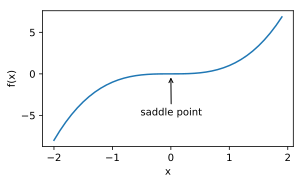

In [6]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

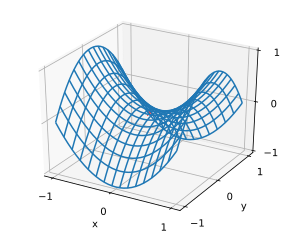

In [7]:
set_figsize((5, 4))
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y');

# Gradient Descent (GD)

## 1. One-dimensional Gradient Descent

In [8]:
def gd(lr):
    x = 10
    results = [x]
    for i in range(10):
        x -= lr * 2 * x
        results.append(x)
        print('epoch {}, x: {}'.format(i, x))
    return results

res = gd(0.2)

epoch 0, x: 6.0
epoch 1, x: 3.5999999999999996
epoch 2, x: 2.1599999999999997
epoch 3, x: 1.2959999999999998
epoch 4, x: 0.7775999999999998
epoch 5, x: 0.46655999999999986
epoch 6, x: 0.2799359999999999
epoch 7, x: 0.16796159999999993
epoch 8, x: 0.10077695999999996
epoch 9, x: 0.06046617599999997


10


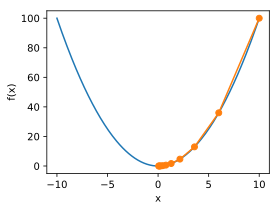

In [9]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    print(n)
    f_line = np.arange(-n, n, 0.1)
    set_figsize()
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

show_trace(res)

Here lr means learning rate This is a super parameter, which needs to be manually set. If a small learning rate is used, it will lead to slow update of x, which requires more iterations to get a better solution.

## 2. Multidimensional Gradient Descent

In [10]:
def train_2d(trainer): 
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(10):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
        print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 1, x1 -4.000000, x2 -1.200000
epoch 2, x1 -3.200000, x2 -0.720000
epoch 3, x1 -2.560000, x2 -0.432000
epoch 4, x1 -2.048000, x2 -0.259200
epoch 5, x1 -1.638400, x2 -0.155520
epoch 6, x1 -1.310720, x2 -0.093312
epoch 7, x1 -1.048576, x2 -0.055987
epoch 8, x1 -0.838861, x2 -0.033592
epoch 9, x1 -0.671089, x2 -0.020155
epoch 10, x1 -0.536871, x2 -0.012093


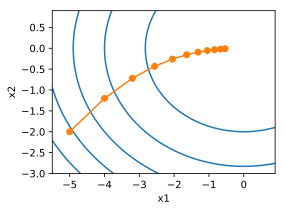

In [11]:
lr = 0.1

def f_2d(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - lr * 2 * x1, x2 - lr * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

## 3. Stochastic Gradient Descent (SGD)

epoch 1, x1 -3.742918, x2 -1.260013
epoch 2, x1 -2.878725, x2 -0.730444
epoch 3, x1 -1.986556, x2 -0.404937
epoch 4, x1 -1.549154, x2 -0.357322
epoch 5, x1 -1.347268, x2 -0.147272
epoch 6, x1 -0.997490, x2 -0.188466
epoch 7, x1 -0.833804, x2 -0.202583
epoch 8, x1 -0.569060, x2 -0.202915
epoch 9, x1 -0.267275, x2 -0.158022
epoch 10, x1 -0.208062, x2 0.006510


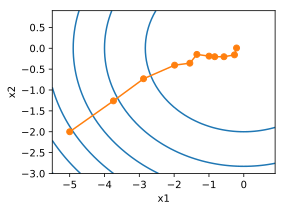

In [12]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - lr * (2 * x1 + np.random.normal(0.1)),
            x2 - lr * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

## 4. Batch Gradient Descent

In [13]:
def get_noise_data():  
    data = np.genfromtxt('airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0) 
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_noise_data()
features.shape

torch.Size([1500, 5])

In [14]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [15]:
def net(X, w, b):
    return torch.mm(X, w) + b

def loss(y_hat, y): 
    return ((y_hat - y.view(y_hat.size())) ** 2) / 2

In [16]:
def train_op(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

loss: 0.242708, 0.039662 sec per epoch


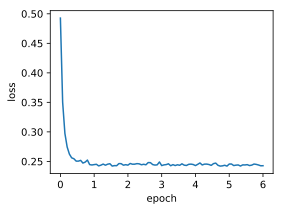

In [17]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_op(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(0.05,10,6)

# Momentum

epoch 1, x1 -4.600000, x2 1.200000
epoch 2, x1 -4.232000, x2 -0.720000
epoch 3, x1 -3.893440, x2 0.432000
epoch 4, x1 -3.581965, x2 -0.259200
epoch 5, x1 -3.295408, x2 0.155520
epoch 6, x1 -3.031775, x2 -0.093312
epoch 7, x1 -2.789233, x2 0.055987
epoch 8, x1 -2.566094, x2 -0.033592
epoch 9, x1 -2.360807, x2 0.020155
epoch 10, x1 -2.171942, x2 -0.012093


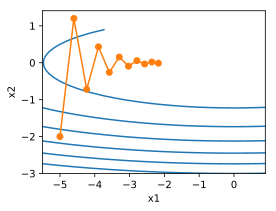

In [18]:
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2


lr = 0.4
def gd_2d(x1, x2, s1, s2):
    return (x1 - lr * 0.2 * x1, x2 - lr * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

epoch 1, x1 -4.300000, x2 3.600000
epoch 2, x1 -3.698000, x2 -6.480000
epoch 3, x1 -3.180280, x2 11.664000
epoch 4, x1 -2.735041, x2 -20.995200
epoch 5, x1 -2.352135, x2 37.791360
epoch 6, x1 -2.022836, x2 -68.024448
epoch 7, x1 -1.739639, x2 122.444006
epoch 8, x1 -1.496090, x2 -220.399212
epoch 9, x1 -1.286637, x2 396.718581
epoch 10, x1 -1.106508, x2 -714.093445


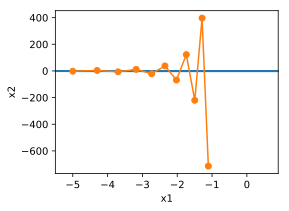

In [19]:
lr = 0.7
show_trace_2d(f_2d, train_2d(gd_2d))

epoch 1, x1 -4.600000, x2 1.200000
epoch 2, x1 -4.032000, x2 0.880000
epoch 3, x1 -3.425440, x2 -0.688000
epoch 4, x1 -2.848125, x2 -0.371200
epoch 5, x1 -2.331617, x2 0.381120
epoch 6, x1 -1.886834, x2 0.147488
epoch 7, x1 -1.513496, x2 -0.205309
epoch 8, x1 -1.205747, x2 -0.053213
epoch 9, x1 -0.955413, x2 0.107976
epoch 10, x1 -0.753813, x2 0.015809


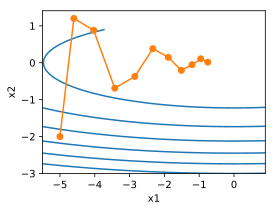

In [20]:
def momentum_2d(x1, x2, v1, v2):
    v1 = rho * v1 + 0.2 * x1
    v2 = rho * v2 + 4 * x2
    return x1 - lr * v1, x2 - lr * v2, v1, v2

lr, rho = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 1, x1 -4.400000, x2 2.800000
epoch 2, x1 -3.572000, x2 -1.520000
epoch 3, x1 -2.729360, x2 -0.032000
epoch 4, x1 -1.980517, x2 0.788800
epoch 5, x1 -1.368433, x2 -0.693920
epoch 6, x1 -0.898179, x2 0.230128
epoch 7, x1 -0.555271, x2 0.139845
epoch 8, x1 -0.317184, x2 -0.240924
epoch 9, x1 -0.160079, x2 0.146909
epoch 10, x1 -0.062317, x2 -0.011756


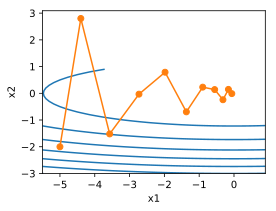

In [21]:
lr = 0.6
show_trace_2d(f_2d, train_2d(momentum_2d))

In [22]:
features, labels = get_noise_data()

# print(features.shape[1])

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.242471, 0.052582 sec per epoch


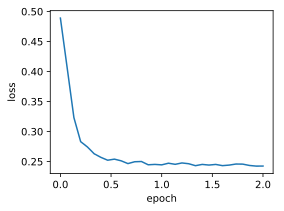

In [23]:
train_op(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.5}, features, labels)

loss: 0.259331, 0.050664 sec per epoch


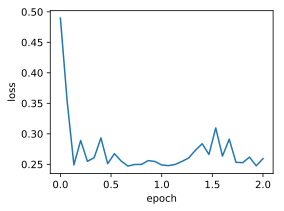

In [24]:
train_op(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

loss: 0.243608, 0.051386 sec per epoch


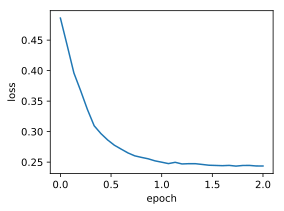

In [25]:
train_op(sgd_momentum, init_momentum_states(),
              {'lr': 0.01, 'momentum': 0.5}, features, labels)

In [26]:
#data = np.genfromtxt('airfoil_self_noise.dat',delimiter='\t')
#data = (data - data.mean(axis=0)) / data.std(axis=0)
#print(data)

# AdaGrad

epoch 1, x1 -4.600000, x2 -1.600000
epoch 2, x1 -4.329177, x2 -1.350122
epoch 3, x1 -4.114228, x2 -1.163597
epoch 4, x1 -3.932301, x2 -1.014436
epoch 5, x1 -3.772835, x2 -0.890767
epoch 6, x1 -3.629932, x2 -0.785968
epoch 7, x1 -3.499909, x2 -0.695875
epoch 8, x1 -3.380281, x2 -0.617648
epoch 9, x1 -3.269280, x2 -0.549239
epoch 10, x1 -3.165593, x2 -0.489098


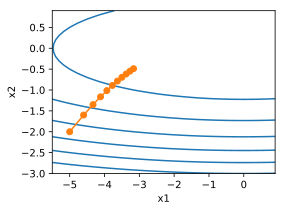

In [27]:
def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-7
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= lr / math.sqrt(s1 + eps) * g1
    x2 -= lr / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

lr = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

epoch 1, x1 -3.000000, x2 -0.000000
epoch 2, x1 -1.971009, x2 -0.000000
epoch 3, x1 -1.330558, x2 -0.000000
epoch 4, x1 -0.907974, x2 -0.000000
epoch 5, x1 -0.622554, x2 -0.000000
epoch 6, x1 -0.427785, x2 -0.000000
epoch 7, x1 -0.294249, x2 -0.000000
epoch 8, x1 -0.202494, x2 -0.000000
epoch 9, x1 -0.139382, x2 -0.000000
epoch 10, x1 -0.095951, x2 -0.000000


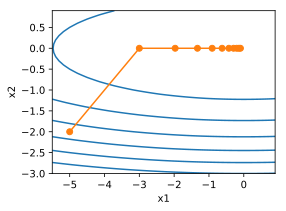

In [28]:
lr = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

In [29]:
features, labels = get_noise_data()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-7
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.244459, 0.052939 sec per epoch


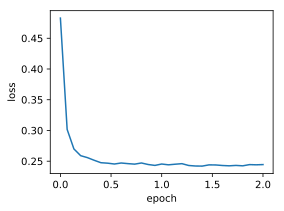

In [30]:
train_op(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

# RMSProp

epoch 1, x1 -3.735093, x2 -0.735089
epoch 2, x1 -2.952554, x2 -0.278126
epoch 3, x1 -2.372978, x2 -0.097741
epoch 4, x1 -1.915250, x2 -0.031013
epoch 5, x1 -1.543068, x2 -0.008699
epoch 6, x1 -1.236420, x2 -0.002101
epoch 7, x1 -0.982684, x2 -0.000421
epoch 8, x1 -0.773050, x2 -0.000066
epoch 9, x1 -0.600835, x2 -0.000007
epoch 10, x1 -0.460615, x2 -0.000000


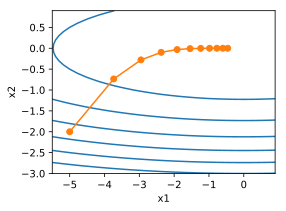

In [31]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= lr / (math.sqrt(s1) + eps) * g1
    x2 -= lr / (math.sqrt(s2) + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

lr, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

In [32]:
features, labels = get_noise_data()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-7
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / (torch.sqrt(s) + eps)

loss: 0.244110, 0.059056 sec per epoch


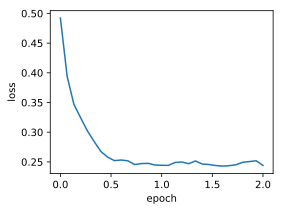

In [33]:
train_op(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

# Adam

In [34]:
def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.246043, 0.085953 sec per epoch


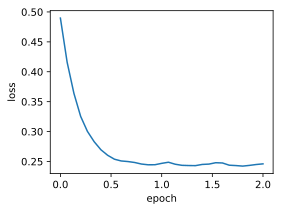

In [35]:
train_op(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

#  Learning Rate Decay

## 1. Linear

In [36]:
def adjust_learning_rate_linear(lr, epoch, total,decay_rate=.9):
        lr = lr * (1 - epoch/total)
        print("lr: ",lr)
        return lr

In [37]:
def sgd_lrd(params, states, hyperparams, epoch, total):
    hyperparams['lr'] = adjust_learning_rate_linear(hyperparams['lr'], epoch, total)
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [38]:
def train_op_lrd(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for e in range(num_epochs):
        print("epoch: ",e)
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            l.backward()
            optimizer_fn([w, b], states, hyperparams, e, num_epochs)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

epoch:  0
lr:  1.0
epoch:  1
lr:  0.95
epoch:  2
lr:  0.855
epoch:  3
lr:  0.72675
epoch:  4
lr:  0.5814
epoch:  5
lr:  0.43605000000000005
epoch:  6
lr:  0.30523500000000003
epoch:  7
lr:  0.19840275000000002
epoch:  8
lr:  0.11904165
epoch:  9
lr:  0.06547290750000001
epoch:  10
lr:  0.032736453750000005
epoch:  11
lr:  0.014731404187500002
epoch:  12
lr:  0.005892561675000001
epoch:  13
lr:  0.00206239658625
epoch:  14
lr:  0.0006187189758750001
epoch:  15
lr:  0.00015467974396875004
epoch:  16
lr:  3.093594879375e-05
epoch:  17
lr:  4.640392319062501e-06
epoch:  18
lr:  4.6403923190625e-07
epoch:  19
lr:  2.3201961595312522e-08
loss: 0.243069, 0.010461 sec per epoch


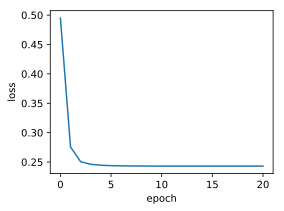

In [39]:
def train_sgd_lrd(lr, batch_size, num_epochs=2):
    train_op_lrd(sgd_lrd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd_lrd(1, 1500, 20)

loss: 0.252080, 0.007399 sec per epoch


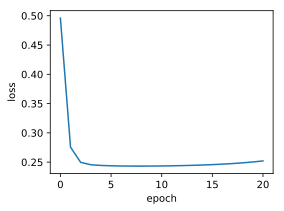

In [40]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_op(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 20)

## 2. Cosine

In [41]:
def adjust_learning_rate_cosine(lr, epoch, total,decay_rate=.9):
        lr = 0.5 * lr * (1 + np.cos(np.pi * epoch/total))
        print("lr: ",lr)
        return lr

In [42]:
def sgd_lrd_cos(params, states, hyperparams, epoch, total):
    hyperparams['lr'] = adjust_learning_rate_cosine(hyperparams['lr'], epoch, total)
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

epoch:  0
lr:  1.0
epoch:  1
lr:  0.9938441702975689
epoch:  2
lr:  0.969523072320511
epoch:  3
lr:  0.9166872275546185
epoch:  4
lr:  0.8291513865863798
epoch:  5
lr:  0.7077249773359188
epoch:  6
lr:  0.5618576408464984
epoch:  7
lr:  0.40846783599844144
epoch:  8
lr:  0.2673456694887594
epoch:  9
lr:  0.15458387313802793
epoch:  10
lr:  0.07729193656901397
epoch:  11
lr:  0.03260040690995841
epoch:  12
lr:  0.0112631635756214
epoch:  13
lr:  0.00307489715763839
epoch:  14
lr:  0.0006337589780312503
epoch:  15
lr:  9.281185351374852e-05
epoch:  16
lr:  8.862743370843898e-06
epoch:  17
lr:  4.829906026073891e-07
epoch:  18
lr:  1.1819621344154363e-08
epoch:  19
lr:  7.275957614183487e-11
loss: 0.242412, 0.034724 sec per epoch


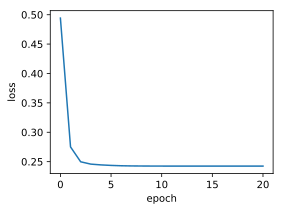

In [43]:
def train_sgd_lrd_cos(lr, batch_size, num_epochs=2):
    train_op_lrd(sgd_lrd_cos, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd_lrd_cos(1, 1500, 20)

## 3. Inverse Sqrt

In [44]:
def adjust_learning_rate_sqrt(lr, epoch, total, decay_rate=.9):
        lr = lr / np.sqrt(epoch + 1)
        print("lr: ",lr)
        return lr

In [45]:
def sgd_lrd_sqrt(params, states, hyperparams, epoch, total):
    hyperparams['lr'] = adjust_learning_rate_sqrt(hyperparams['lr'], epoch, total)
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

epoch:  0
lr:  1.0
epoch:  1
lr:  0.7071067811865475
epoch:  2
lr:  0.408248290463863
epoch:  3
lr:  0.2041241452319315
epoch:  4
lr:  0.09128709291752768
epoch:  5
lr:  0.037267799624996496
epoch:  6
lr:  0.014085904245475275
epoch:  7
lr:  0.0049801192055599726
epoch:  8
lr:  0.0016600397351866575
epoch:  9
lr:  0.0005249506569572599
epoch:  10
lr:  0.0001582785784161638
epoch:  11
lr:  4.569108992776173e-05
epoch:  12
lr:  1.2672428274337011e-05
epoch:  13
lr:  3.3868489186454308e-06
epoch:  14
lr:  8.744806305356234e-07
epoch:  15
lr:  2.1862015763390585e-07
epoch:  16
lr:  5.302317657728099e-08
epoch:  17
lr:  1.2497682572615701e-08
epoch:  18
lr:  2.867165019077961e-09
epoch:  19
lr:  6.411175885367802e-10
loss: 0.247777, 0.008688 sec per epoch


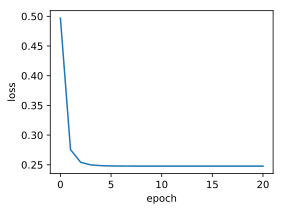

In [46]:
def train_sgd_lrd_sqrt(lr, batch_size, num_epochs=2):
    train_op_lrd(sgd_lrd_sqrt, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd_lrd_sqrt(1, 1500, 20)

# Regularization

## 1. Dropout

In [47]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.randn(X.shape) < keep_prob).float()
    return mask * X / keep_prob

In [48]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [49]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training: 
        H1 = dropout(H1, drop_prob1)  
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

In [50]:
def load_data_fashion_mnist(batch_size, resize=None, root='./Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter


In [51]:
def SGD(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size 

In [52]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train()
        else: 
            if('is_training' in net.__code__.co_varnames):
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

In [53]:
def train_drop(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                SGD(params, lr, batch_size)
            else:
                optimizer.step()
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


In [54]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_drop(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0042, train acc 0.584, test acc 0.785
epoch 2, loss 0.0022, train acc 0.791, test acc 0.784
epoch 3, loss 0.0018, train acc 0.826, test acc 0.833
epoch 4, loss 0.0017, train acc 0.841, test acc 0.744
epoch 5, loss 0.0016, train acc 0.846, test acc 0.844


In [55]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): 
        return x.view(x.shape[0], -1)

In [56]:
net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [57]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_drop(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0044, train acc 0.553, test acc 0.737
epoch 2, loss 0.0022, train acc 0.785, test acc 0.816
epoch 3, loss 0.0019, train acc 0.823, test acc 0.757
epoch 4, loss 0.0018, train acc 0.835, test acc 0.844
epoch 5, loss 0.0016, train acc 0.850, test acc 0.816


## 2. Dropout Visualization

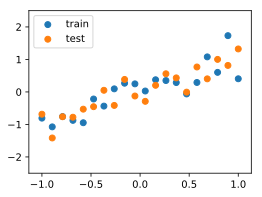

In [58]:
DATA_SIZE = 20

x = torch.unsqueeze(torch.linspace(-1, 1, DATA_SIZE), dim=1) # sieze (20,1)
y = x + 0.3*torch.normal(torch.zeros(DATA_SIZE, 1), torch.ones(DATA_SIZE, 1))
x, y = Variable(x), Variable(y) 

test_x = torch.unsqueeze(torch.linspace(-1, 1, DATA_SIZE), dim=1)
test_y = test_x + 0.3*torch.normal(torch.zeros(DATA_SIZE,1), torch.ones(DATA_SIZE,1))
test_x, test_y = Variable(test_x), Variable(test_y)

plt.scatter(x.data.numpy(), y.data.numpy(), label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

In [59]:
N_HIDDEN = 100
net_nodropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),    
    torch.nn.ReLU(),                    
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),                     
    torch.nn.Linear(N_HIDDEN, 1)
)

net_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),          
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1)
)

print('net_nodropout: \n', net_nodropout)
print('\n net_dropout: \n', net_dropout)

net_nodropout: 
 Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

 net_dropout: 
 Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Dropout(p=0.5)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): Dropout(p=0.5)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)


In [60]:
optimizer_nodropout = torch.optim.Adam(net_nodropout.parameters(), lr=0.01)
optimizer_dropout = torch.optim.Adam(net_dropout.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for t in range(1000):
    prediction_nodropout = net_nodropout(x)
    prediction_dropout = net_dropout(x)
    loss_nodropout = loss_func(prediction_nodropout, y)
    loss_dropout = loss_func(prediction_dropout, y)

    optimizer_nodropout.zero_grad()
    optimizer_dropout.zero_grad()
    loss_nodropout.backward()
    loss_dropout.backward()
    optimizer_nodropout.step()
    optimizer_dropout.step()

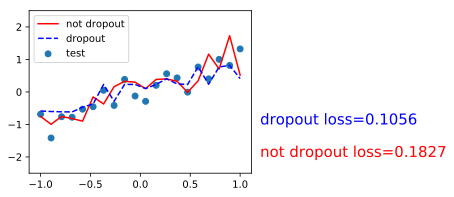

In [61]:
net_dropout.eval()      
test_prediction_nodropout = net_nodropout(test_x)
test_prediction_dropout = net_dropout(test_y)

plt.scatter(test_x.data.numpy(), test_y.data.numpy(), label='test')
plt.plot(test_x.data.numpy(), test_prediction_nodropout.data.numpy(),'r-', label='not dropout')
plt.plot(test_x.data.numpy(), test_prediction_dropout.data.numpy(), 'b--', label='dropout')
plt.text(1.2, -2, 'not dropout loss=%.4f' % loss_func(test_prediction_nodropout, test_y).item(), fontdict={'size': 15, 'color':  'red'})
plt.text(1.2, -1, 'dropout loss=%.4f' % loss_func(test_prediction_dropout, test_y).item(), fontdict={'size': 15, 'color': 'blue'})
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

## 3.Batch Normalization

In [62]:
def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not is_training:
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [63]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(self.training, 
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [64]:
net_BN = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    BatchNorm(N_HIDDEN, num_dims=2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    BatchNorm(N_HIDDEN, num_dims=2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1)
)

In [65]:
optimizer_nodropout = torch.optim.Adam(net_nodropout.parameters(), lr=0.01)
optimizer_BN = torch.optim.Adam(net_BN.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for t in range(1000):
    # train the NN by training set
    prediction_nodropout = net_nodropout(x)
    prediction_BN = net_BN(x)
    loss_nodropout = loss_func(prediction_nodropout, y)
    loss_BN = loss_func(prediction_BN, y)

    optimizer_nodropout.zero_grad()
    optimizer_BN.zero_grad()
    loss_nodropout.backward()
    loss_BN.backward()
    optimizer_dropout.step()
    optimizer_BN.step()

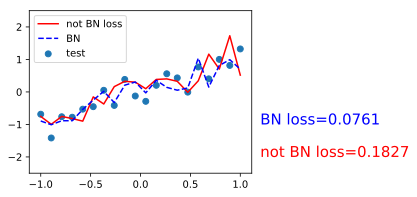

In [66]:
net_BN.eval()      
test_prediction_dropout= net_dropout(test_x)
test_prediction_BN = net_BN(test_y)

plt.scatter(test_x.data.numpy(), test_y.data.numpy(), label='test')
plt.plot(test_x.data.numpy(), test_prediction_nodropout.data.numpy(),'r-', label='not BN loss')
plt.plot(test_x.data.numpy(), test_prediction_BN.data.numpy(), 'b--', label='BN')
plt.text(1.2, -2, 'not BN loss=%.4f' % loss_func(test_prediction_nodropout, test_y).item(), fontdict={'size': 15, 'color':  'red'})
plt.text(1.2, -1, 'BN loss=%.4f' % loss_func(test_prediction_BN, test_y).item(), fontdict={'size': 15, 'color': 'blue'})
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

## LeNet

In [67]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), 
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
    
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [68]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [69]:
def evaluate_accuracy(data_iter, net):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() 
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()
            else: 
                if('is_training' in net.__code__.co_varnames): 
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [70]:
def train_BN(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [71]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_BN(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 1.8574, train acc 0.318, test acc 0.570, time 3.4 sec
epoch 2, loss 0.4757, train acc 0.627, test acc 0.663, time 2.1 sec
epoch 3, loss 0.2579, train acc 0.712, test acc 0.725, time 2.1 sec
epoch 4, loss 0.1709, train acc 0.741, test acc 0.744, time 2.1 sec
epoch 5, loss 0.1247, train acc 0.758, test acc 0.759, time 2.0 sec


In [72]:
net_BN = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            FlattenLayer(),
            nn.Linear(16*4*4, 120),
            nn.BatchNorm1d(120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

In [73]:
optimizer = torch.optim.Adam(net_BN.parameters(), lr=lr)
train_BN(net_BN, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 1.3905, train acc 0.773, test acc 0.787, time 2.3 sec
epoch 2, loss 0.3041, train acc 0.856, test acc 0.827, time 2.5 sec
epoch 3, loss 0.1391, train acc 0.874, test acc 0.840, time 2.2 sec
epoch 4, loss 0.0884, train acc 0.884, test acc 0.809, time 2.6 sec
epoch 5, loss 0.0650, train acc 0.890, test acc 0.869, time 2.4 sec


## 4. Data Augmentation

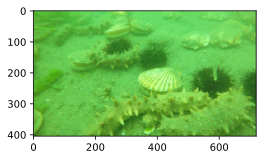

In [74]:
set_figsize()
img = Image.open('Datasets/scallop.jpg')
plt.imshow(img)

In [75]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [76]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

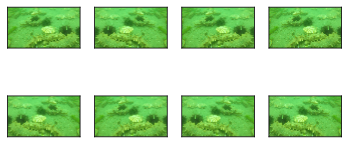

In [77]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

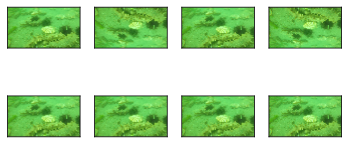

In [78]:
apply(img, torchvision.transforms.RandomVerticalFlip())

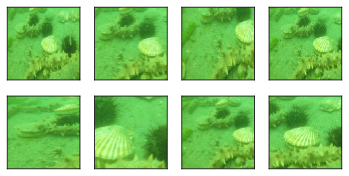

In [79]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

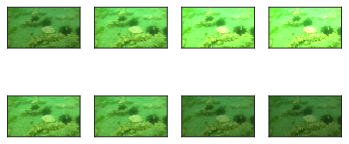

In [80]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

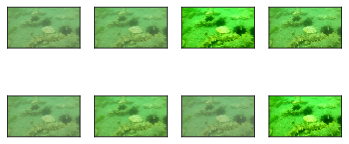

In [81]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0))

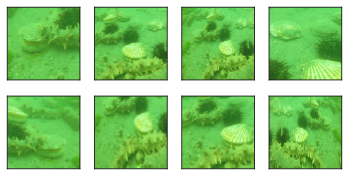

In [82]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), shape_aug])
apply(img, augs)

# Comprehensive Task

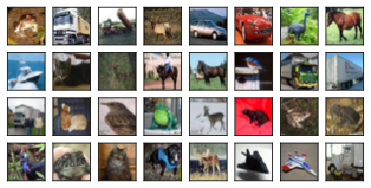

In [83]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="Datasets/CIFAR", download=False)

show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [84]:
class GlobalAvgPool2d(nn.Module):

    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

In [85]:
class Residual(nn.Module): 
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)
    
def resnet18(output=10, in_channels=3):
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
    net.add_module("fc", nn.Sequential(FlattenLayer(), nn.Linear(512, output))) 
    return net


In [86]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [87]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=False)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [88]:
def evaluate_accuracy(data_iter, net, 
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() #
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() 
            else: 
                if('is_training' in net.__code__.co_varnames): 
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [89]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [90]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [91]:
train_with_data_aug(train_augs=no_aug, test_augs=no_aug)

training on  cuda
epoch 1, loss 1.3576, train acc 0.506, test acc 0.385, time 32.5 sec
epoch 2, loss 0.4917, train acc 0.650, test acc 0.603, time 32.3 sec
epoch 3, loss 0.2733, train acc 0.713, test acc 0.608, time 32.3 sec
epoch 4, loss 0.1753, train acc 0.754, test acc 0.681, time 32.4 sec
epoch 5, loss 0.1203, train acc 0.791, test acc 0.676, time 32.4 sec
epoch 6, loss 0.0854, train acc 0.822, test acc 0.717, time 32.4 sec
epoch 7, loss 0.0616, train acc 0.851, test acc 0.722, time 32.4 sec
epoch 8, loss 0.0452, train acc 0.874, test acc 0.714, time 32.8 sec
epoch 9, loss 0.0329, train acc 0.898, test acc 0.724, time 33.2 sec
epoch 10, loss 0.0244, train acc 0.916, test acc 0.716, time 33.1 sec


In [92]:
train_with_data_aug(train_augs=flip_aug, test_augs=no_aug)

training on  cuda
epoch 1, loss 1.3642, train acc 0.502, test acc 0.533, time 33.1 sec
epoch 2, loss 0.4986, train acc 0.649, test acc 0.632, time 32.9 sec
epoch 3, loss 0.2811, train acc 0.701, test acc 0.631, time 33.1 sec
epoch 4, loss 0.1889, train acc 0.735, test acc 0.601, time 33.6 sec
epoch 5, loss 0.1352, train acc 0.762, test acc 0.625, time 35.0 sec
epoch 6, loss 0.1016, train acc 0.788, test acc 0.704, time 34.5 sec
epoch 7, loss 0.0816, train acc 0.801, test acc 0.672, time 33.5 sec
epoch 8, loss 0.0640, train acc 0.822, test acc 0.736, time 32.7 sec
epoch 9, loss 0.0528, train acc 0.834, test acc 0.743, time 32.7 sec
epoch 10, loss 0.0434, train acc 0.848, test acc 0.740, time 32.7 sec
